In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mytorch.nn.activation import ReLU, Sigmoid, Tanh, LinearActivation
from mytorch.nn.initialization import Xavier, He
from mytorch.nn.linear import Linear
from mytorch.nn.loss import CrossEntropyLoss, L2Loss
from mytorch.optim.optimizer import SGD, Adam
from models.mlp import MLP
import numpyNN

In [2]:
# based on dataset.py from IML HW 6 
def one_hot_encoding(y, num_classes=2):
    one_hot = np.eye(num_classes)[y.astype(int).flatten()]
    return one_hot

In [3]:
def train_and_test_mlp(mlp, x_train, y_train, x_test, y_test, opt_loss, opt_optim, num_epoch=20, batch_size=32):
    assert x_train.shape[0] == y_train.shape[0], "x_train and y_train must have the same length"
    assert x_test.shape[0] == y_test.shape[0], "x_test and y_test must have the same length"

    train_loss, train_accuracy = [], []
    test_loss, test_accuracy = [], []

    y_train_encoded = one_hot_encoding(y_train)  # Make sure this function correctly encodes y_train to the desired format
    y_test_encoded = one_hot_encoding(y_test)  # And y_test

    for epoch in range(num_epoch):
        # Shuffle training data and labels
        indices = np.arange(x_train.shape[0])
        np.random.shuffle(indices)
        x_train_shuffled = x_train[indices]
        y_train_shuffled = y_train_encoded[indices]

        batch_losses = []
        batch_accuracies = []

        # Training with mini-batches
        for start_idx in range(0, x_train.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, x_train.shape[0])
            batch_x = x_train_shuffled[start_idx:end_idx]
            batch_y = y_train_shuffled[start_idx:end_idx]

            y_pred_train = mlp.forward(batch_x)
            loss_train = opt_loss.forward(y_pred_train, batch_y)
            batch_losses.append(np.mean(loss_train))

            dLdZ = opt_loss.backward()  # Use correct call for backward computation
            mlp.backward(dLdZ)
            opt_optim.step()
            opt_optim.zero_grad()

            predicted_labels_train = np.argmax(y_pred_train, axis=1)
            true_labels_train = np.argmax(batch_y, axis=1)
            accuracy_train = np.sum(predicted_labels_train == true_labels_train) / len(batch_x)
            batch_accuracies.append(accuracy_train)

        # Compute mean loss and accuracy for the epoch
        epoch_loss = np.mean(batch_losses)
        epoch_accuracy = np.mean(batch_accuracies)
        train_loss.append(epoch_loss)
        train_accuracy.append(epoch_accuracy)

        # Testing (evaluate the model with the current state on the test set)
        mlp_eval = mlp.copy()  # Ensure your MLP class has a proper copy method
        y_pred_test = mlp_eval.forward(x_test)
        loss_test = opt_loss.forward(y_pred_test, y_test_encoded)
        test_loss.append(np.mean(loss_test))

        predicted_labels_test = np.argmax(y_pred_test, axis=1)
        true_labels_test = np.argmax(y_test_encoded, axis=1)
        accuracy_test = np.sum(predicted_labels_test == true_labels_test) / len(x_test)
        test_accuracy.append(accuracy_test)

        print(f"Epoch: {epoch}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}, Test Loss: {np.mean(loss_test)}, Test Accuracy: {accuracy_test}")

    logs = {
        "train_loss": train_loss,
        "train_accuracy": train_accuracy,
        "test_loss": test_loss,
        "test_accuracy": test_accuracy
    }
    return logs


In [4]:
x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'linear-separable',nTrain=200, nTest=100)

In [5]:
dim_in, dim_out = x_train.shape[1], 2
hidden_neuron_list = [2,4]
activation_list = ['ReLU', 'ReLU', 'Sigmoid']
opt_init = None
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = SGD(mlp, lr_decay=.1, decay_iter=30)

In [6]:
dim_in, dim_out = x_train.shape[1], 2
hidden_neuron_list = [4,4]
activation_list = ['ReLU', 'ReLU', 'LinearActivation']
opt_init = 'xavier'
opt_loss = CrossEntropyLoss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = SGD(mlp, lr_decay=1, decay_iter=30, momentum=0.9)

In [7]:
mlp.summary()

Model Summary
-------------
Layer 1: Linear - A Dim: 2, Output Dim: 4, Parameters: 12
Layer 2: ReLU
Layer 3: Linear - A Dim: 4, Output Dim: 4, Parameters: 20
Layer 4: ReLU
Layer 5: Linear - A Dim: 4, Output Dim: 2, Parameters: 10
Layer 6: LinearActivation
Total Parameters: 42


In [8]:
logs = train_and_test_mlp(mlp, x_train, y_train, x_test, y_test, opt_loss, opt_optim, num_epoch=100)

Epoch: 0, Train Loss: 0.7466841029733366, Train Accuracy: 0.35714285714285715, Test Loss: 0.6567058581758947, Test Accuracy: 0.47
Epoch: 1, Train Loss: 0.6870252346029005, Train Accuracy: 0.4642857142857143, Test Loss: 0.6180180995285209, Test Accuracy: 0.61
Epoch: 2, Train Loss: 0.6461028726837312, Train Accuracy: 0.6160714285714286, Test Loss: 0.5963965731711568, Test Accuracy: 0.71
Epoch: 3, Train Loss: 0.6262281371346197, Train Accuracy: 0.6919642857142857, Test Loss: 0.5741858323105726, Test Accuracy: 0.75
Epoch: 4, Train Loss: 0.6062896499154198, Train Accuracy: 0.7142857142857143, Test Loss: 0.5528831377150653, Test Accuracy: 0.78
Epoch: 5, Train Loss: 0.5803335290904564, Train Accuracy: 0.7633928571428571, Test Loss: 0.5224091166110157, Test Accuracy: 0.85
Epoch: 6, Train Loss: 0.5507207139730333, Train Accuracy: 0.8035714285714286, Test Loss: 0.4905737475732529, Test Accuracy: 0.87
Epoch: 7, Train Loss: 0.5261677411598926, Train Accuracy: 0.8169642857142857, Test Loss: 0.45132

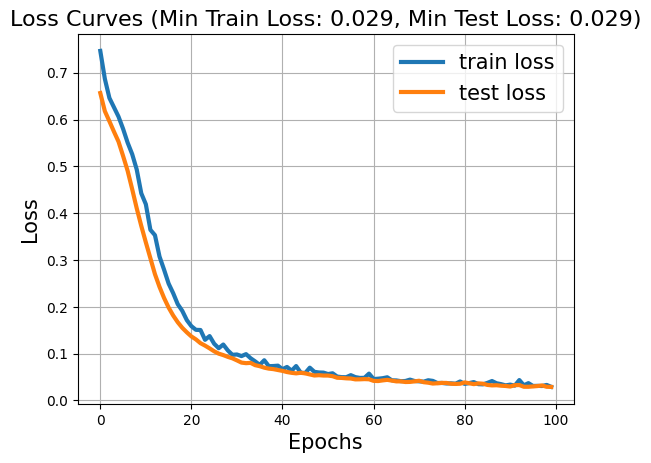

In [9]:
numpyNN.plot_loss(logs)

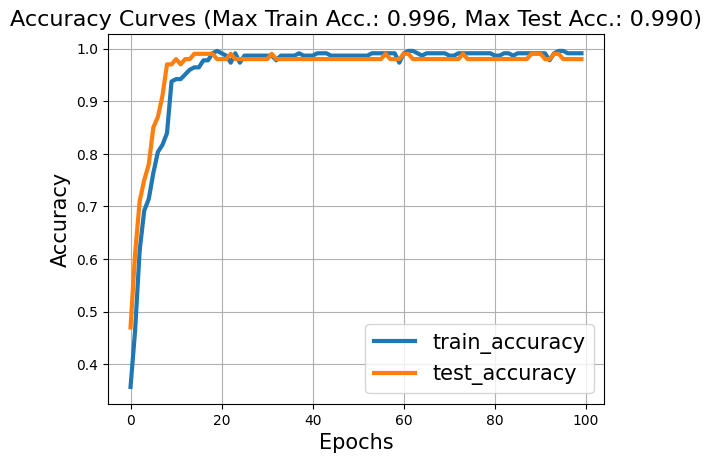

In [10]:
numpyNN.plot_accuracy(logs)

In [11]:

def plot_decision_boundary(X, y, model, boundry_level=None):
    """
    Plots the decision boundary for the model prediction
    :param X: input data
    :param y: true labels
    :param model: your MLP model
    :boundry_level: Determines the number and positions of the contour lines / regions.
    :return:
    """
    print(X.shape)
    print(y.shape)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))
    def predict(X):
        y_pred = model.forward(X)
        return np.argmax(y_pred, axis=1)


    # Use the predict function as pred_fn
    Z = predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, alpha=0.7, levels=boundry_level, cmap='viridis_r')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.scatter(X[:, 0], X[:, 1], c=y.reshape(-1), alpha=0.7,s=50, cmap='viridis_r', edgecolor='k')

(200, 2)
(200, 1)


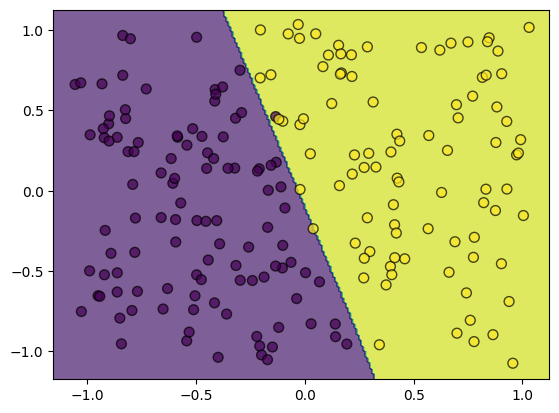

In [12]:
# predicted_labels = np.argmax(y_pred, axis=1)
plot_decision_boundary(x_train, y_train, mlp , boundry_level=None)

(100, 2)
(100, 1)


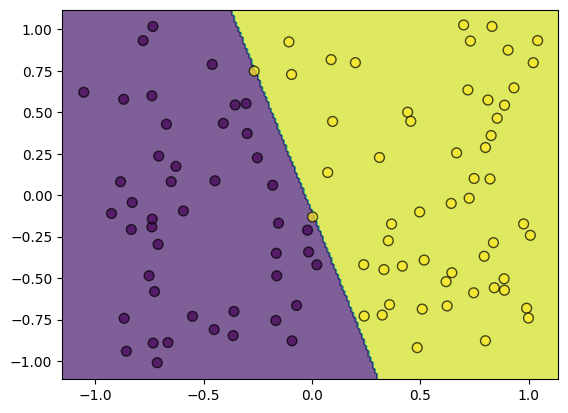

In [13]:
plot_decision_boundary(x_test, y_test, mlp , boundry_level=None)


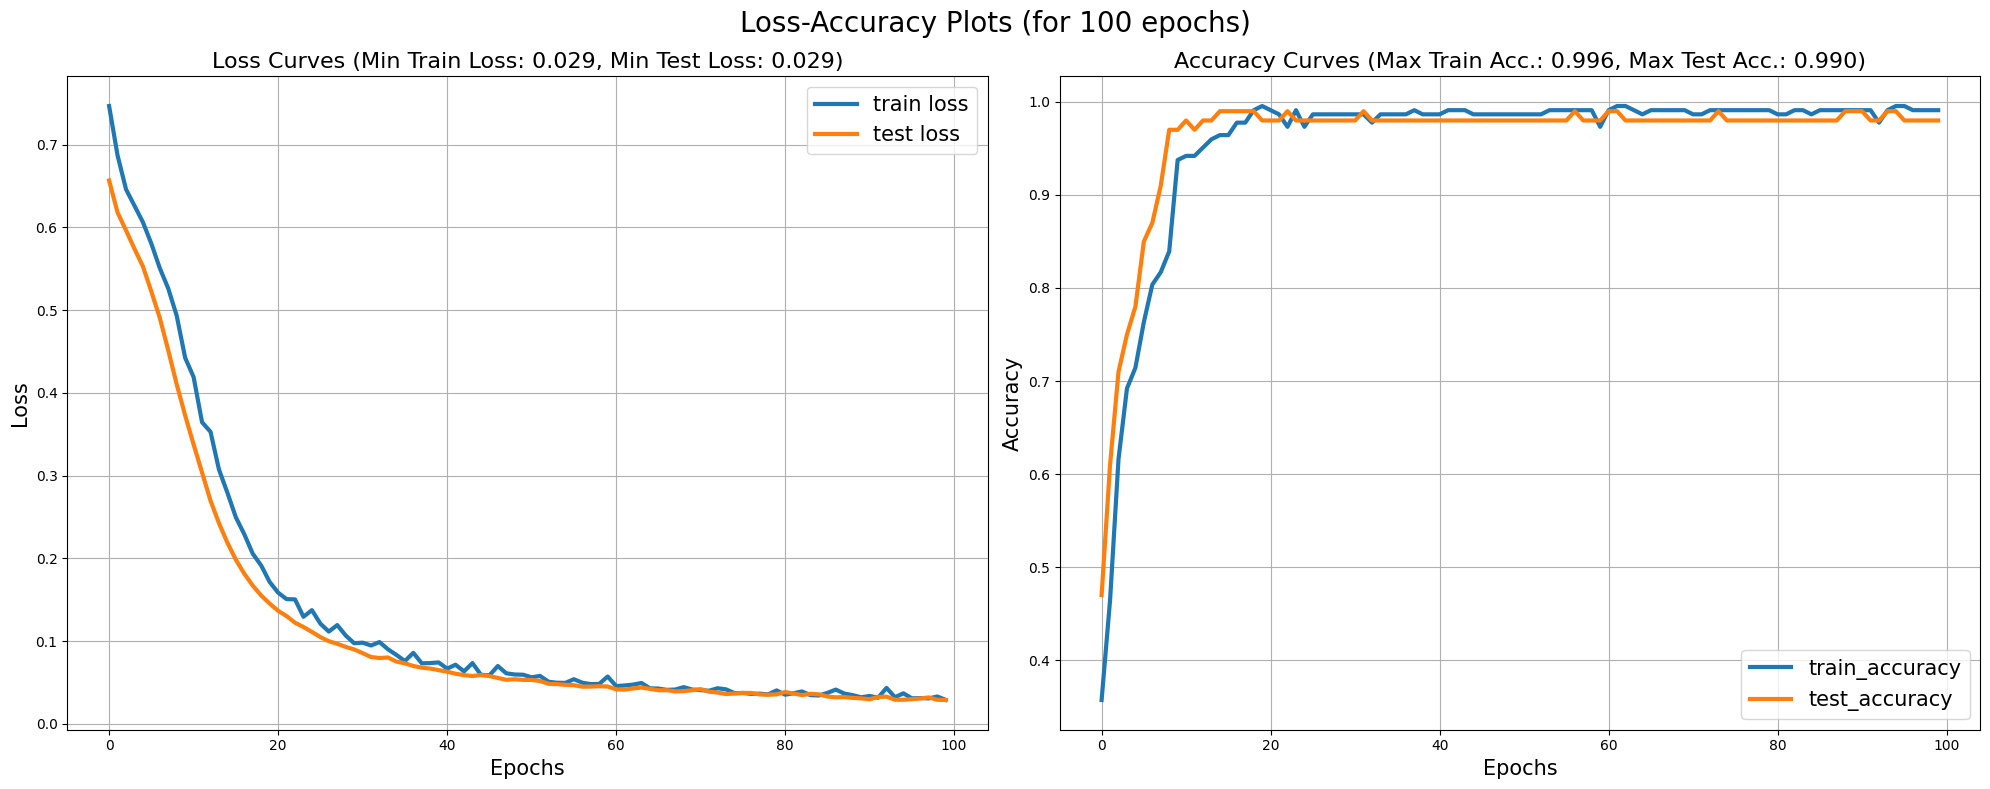

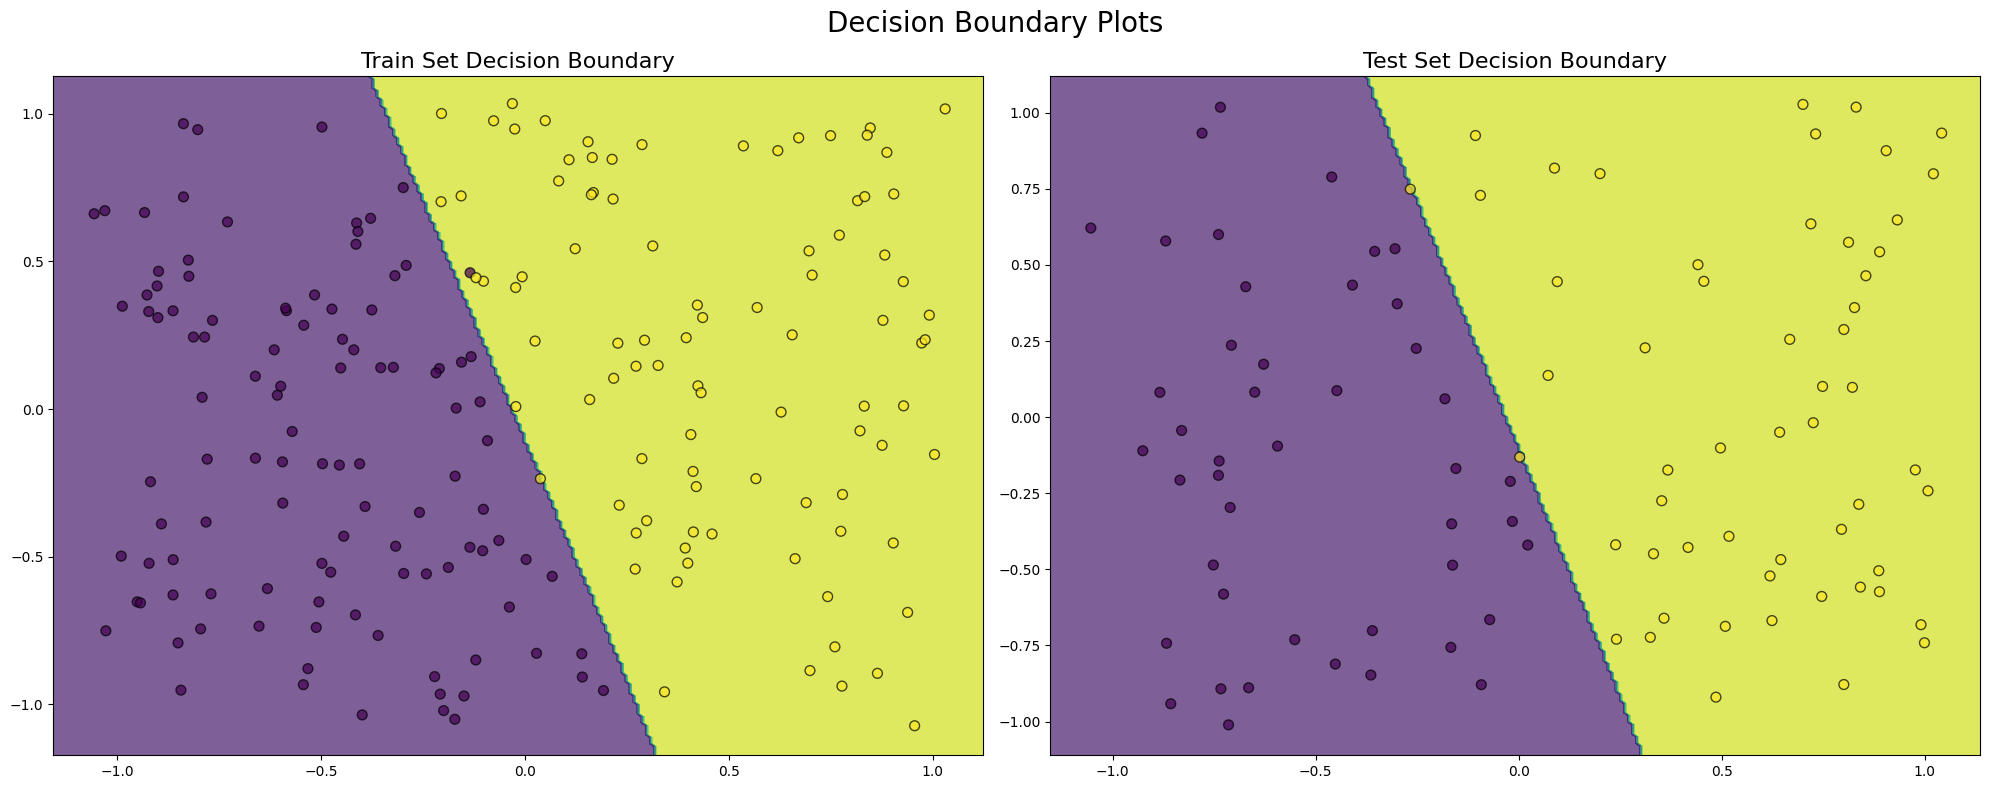

In [14]:
numpyNN.plot_stats(logs, mlp, x_train, y_train, x_test, y_test, 'linear-la', 'linear-db')

---

In [15]:

x_train, y_train, x_test, y_test = numpyNN.sample_data(data_name = 'linear-separable',nTrain=2, nTest=2)

In [16]:
dim_in, dim_out = x_train.shape[1], 2
hidden_neuron_list = [2,4]
activation_list = ['ReLU', 'ReLU', 'Sigmoid']
opt_init = None
opt_loss = L2Loss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = SGD(lr_decay=1, decay_iter=30)

print(mlp.summary())

TypeError: SGD.__init__() missing 1 required positional argument: 'model'

In [ ]:
print(mlp.get_parameters())

AttributeError: 'MLP' object has no attribute 'get_parameters'

In [ ]:
y_pred = mlp.forward(x_train)
y_train = one_hot_encoding(y_train)
loss = opt_loss.forward(y_pred, y_train)

In [ ]:
y_pred[1:4], y_train[1:4], loss[1:4]

(array([[0.49148908, 0.51897857]]), array([[1., 0.]]), array([0.26396106]))

In [ ]:
predicted_labels = np.argmax(y_pred, axis=1)
true_labels = np.argmax(y_train, axis=1)  # Adjust this line if train_y is not one-hot encoded
accuracy = np.sum(predicted_labels == true_labels) / len(x_train)
print(accuracy)

0.0


In [ ]:
print("Before backward:", mlp.layers[0].parameters[0]['params'].mean())

Before backward: 0.12392863696006


In [ ]:
dLdZ = opt_loss.backward(y_pred, y_train)
dLdZ[1:10]

array([[-0.50851092,  0.51897857]])

In [ ]:
dLdZ.shape

(2, 2)

In [ ]:
mlp.get_parameters()

[{'params': array([[ 0.81526991,  0.22909795],
         [-1.02617878,  0.47752547]]),
  'grad': 0.0},
 {'params': array([[0., 0.]]), 'grad': 0.0},
 {'params': array([[ 1.29269823, -0.73145824, -1.60540226,  0.98947618],
         [ 0.11081461, -0.38093141,  0.11495917,  0.34531264]]),
  'grad': 0.0},
 {'params': array([[0., 0., 0., 0.]]), 'grad': 0.0},
 {'params': array([[-1.73495876,  1.65835111],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.0657892 , -0.69993739]]),
  'grad': 0.0},
 {'params': array([[0., 0.]]), 'grad': 0.0}]

In [ ]:
mlp.backward(dLdZ)

array([[ 0.81526991, -1.02617878],
       [ 1.04436786, -0.54865331]])

In [ ]:
mlp.get_parameters()

[{'params': array([[ 0.81526991,  0.22909795],
         [-1.02617878,  0.47752547]]),
  'grad': array([[0.78397459, 0.40706704],
         [0.05325339, 0.26387176]])},
 {'params': array([[0., 0.]]), 'grad': array([[2, 1]])},
 {'params': array([[ 1.29269823, -0.73145824, -1.60540226,  0.98947618],
         [ 0.11081461, -0.38093141,  0.11495917,  0.34531264]]),
  'grad': array([[0.58450339, 0.        , 0.        , 0.58450339],
         [0.21926371, 0.        , 0.        , 0.21926371]])},
 {'params': array([[0., 0., 0., 0.]]), 'grad': array([[2, 0, 0, 2]])},
 {'params': array([[-1.73495876,  1.65835111],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.0657892 , -0.69993739]]),
  'grad': array([[-0.11319316,  0.1134724 ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [-0.09390094,  0.09425557]])},
 {'params': array([[0., 0.]]), 'grad': array([[-0.2749868 ,  0.27748981]])}]

In [ ]:
print("Before optimization:", mlp.layers[0].parameters[0]['params'].mean())

Before optimization: 0.12392863696006


In [ ]:
opt_optim.step(mlp.get_parameters())

0 Initialized v
1 v
1 v
1 v
1 v
1 v
1 v


In [ ]:
mlp.get_parameters()

[{'params': array([[ 0.80743016,  0.22502728],
         [-1.02671131,  0.47488675]]),
  'grad': array([[0.78397459, 0.40706704],
         [0.05325339, 0.26387176]])},
 {'params': array([[-0.02, -0.01]]), 'grad': array([[2, 1]])},
 {'params': array([[ 1.2868532 , -0.73145824, -1.60540226,  0.98363114],
         [ 0.10862197, -0.38093141,  0.11495917,  0.34312001]]),
  'grad': array([[0.58450339, 0.        , 0.        , 0.58450339],
         [0.21926371, 0.        , 0.        , 0.21926371]])},
 {'params': array([[-0.02,  0.  ,  0.  , -0.02]]),
  'grad': array([[2, 0, 0, 2]])},
 {'params': array([[-1.73382683,  1.65721638],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.06672821, -0.70087994]]),
  'grad': array([[-0.11319316,  0.1134724 ],
         [ 0.        ,  0.        ],
         [ 0.        ,  0.        ],
         [-0.09390094,  0.09425557]])},
 {'params': array([[ 0.00274987, -0.0027749 ]]),
  'grad': array([[-0.2749868 ,  0.27748981]])}]

In [ ]:
print("After optimization:", mlp.layers[0].parameters[0]['params'].mean())

After optimization: 0.1201582200088189


In [ ]:
opt_optim.zero_grad(mlp.get_parameters())

In [ ]:
mlp.get_parameters()

[{'params': array([[ 0.80743016,  0.22502728],
         [-1.02671131,  0.47488675]]),
  'grad': array([[0., 0.],
         [0., 0.]])},
 {'params': array([[-0.02, -0.01]]), 'grad': array([[0, 0]])},
 {'params': array([[ 1.2868532 , -0.73145824, -1.60540226,  0.98363114],
         [ 0.10862197, -0.38093141,  0.11495917,  0.34312001]]),
  'grad': array([[0., 0., 0., 0.],
         [0., 0., 0., 0.]])},
 {'params': array([[-0.02,  0.  ,  0.  , -0.02]]),
  'grad': array([[0, 0, 0, 0]])},
 {'params': array([[-1.73382683,  1.65721638],
         [ 2.29977152, -0.47113526],
         [ 1.26271548, -1.17051545],
         [ 1.06672821, -0.70087994]]),
  'grad': array([[0., 0.],
         [0., 0.],
         [0., 0.],
         [0., 0.]])},
 {'params': array([[ 0.00274987, -0.0027749 ]]), 'grad': array([[0., 0.]])}]

In [ ]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class TorchMLP(nn.Module):
#     def __init__(self, input_dim, hidden_dims, output_dim):
#         super(TorchMLP, self).__init__()
#         # Define the first hidden layer
#         self.hidden1 = nn.Linear(input_dim, hidden_dims[0])
#         # Define the second hidden layer
#         self.hidden2 = nn.Linear(hidden_dims[0], hidden_dims[1])
#         # Define the output layer
#         self.output = nn.Linear(hidden_dims[1], output_dim)
    
#     def forward(self, x):
#         # Pass the input through the first hidden layer and apply ReLU
#         x = F.relu(self.hidden1(x))
#         # Pass the result through the second hidden layer and apply ReLU
#         x = F.relu(self.hidden2(x))
#         # Pass the result through the output layer and apply Softmax
#         # Note: Softmax is typically applied outside the model for numerical stability
#         x = self.output(x)
#         return x

# # Initialize the model
# input_dim = 2  # Assuming 2 features in the input data
# hidden_neuron_list = [2,3]
# output_dim = 2  # Output dimension for binary classification (use with softmax)
# model = TorchMLP(input_dim, hidden_neuron_list, output_dim)

# # Print the model summary
# print(model)

# # Calculate the number of parameters
# total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(f"Total number of parameters: {total_params}")


In [ ]:
# y_train = one_hot_encoding(y_train)
dim_in, dim_out = x_train.shape[1], 2
hidden_neuron_list = [2,2]
activation_list = ['Tanh', 'ReLU', 'Sigmoid']
opt_init = None
opt_loss = CrossEntropyLoss()
mlp = MLP(dim_in, dim_out, hidden_neuron_list, activation_list, opt_init)
opt_optim = Adam(lr_decay=1, decay_iter=30)

In [ ]:
for i in range(3):
    print('Epoch', i)
    print(mlp.get_parameters())
    y_pred = mlp.forward(x_train)
    loss = opt_loss.forward(y_pred, y_train)
    # y_pred[1:4], y_train[1:4], loss[1:4]
    predicted_labels = np.argmax(y_pred, axis=1)
    true_labels = np.argmax(y_train, axis=1)  # Adjust this line if train_y is not one-hot encoded
    accuracy = np.sum(predicted_labels == true_labels) / len(x_train)
    print(accuracy)
    print("Before backward:", mlp.layers[0].parameters[0]['params'].mean())
    print(mlp.get_parameters())

    dLdZ = opt_loss.backward(y_pred, y_train)
    dLdZ[1:10]
    dLdZ.shape
    print("After backward:", mlp.layers[0].parameters[0]['params'].mean())
    print(mlp.get_parameters())
    mlp.backward(dLdZ)
    print("Before optimization:", mlp.layers[0].parameters[0]['params'].mean())
    opt_optim.step(mlp.get_parameters())
    print("After optimization:", mlp.layers[0].parameters[0]['params'].mean())
    opt_optim.zero_grad(mlp.get_parameters())
    print("After 0:", mlp.layers[0].parameters[0]['params'].mean())
    print(mlp.get_parameters())

Epoch 0
[{'params': array([[-0.99838235, -0.3676376 ],
       [ 1.73719932,  0.59361275]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[-0.54236358, -1.71967238],
       [-0.57890879,  1.42694855]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[0.27699691, 0.78966713],
       [0.32207411, 0.70039238]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}]
0.5
Before backward: 0.24119802808082583
[{'params': array([[-0.99838235, -0.3676376 ],
       [ 1.73719932,  0.59361275]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[-0.54236358, -1.71967238],
       [-0.57890879,  1.42694855]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}, {'params': array([[0.27699691, 0.78966713],
       [0.32207411, 0.70039238]]), 'grad': 0.0}, {'params': array([[0., 0.]]), 'grad': 0.0}]
After backward: 0.24119802808082583
[{'params': array([[-0.99838235, -0.3676376 ],
       [ 1.73719932,  0.5936